In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from PIL import Image
import os

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Flatten y labels (original shape: (n,1))
y_train = y_train.flatten()
y_test = y_test.flatten()

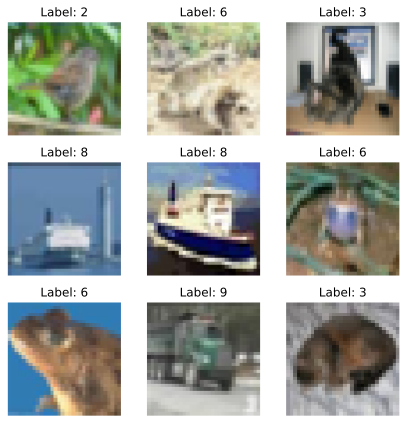

In [17]:
plt.figure(figsize=(6, 6))

for i in range(9):
    idx = np.random.randint(0, len(x_train))
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[idx])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.1,      # 10% validation set
    random_state=42,    # reproducible
    stratify=y_train    # keeps class balance
)

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,          # stop after 3 epochs with no improvement
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,          # reduce LR by half
        patience=2,          # wait 2 epochs before reducing LR
        min_lr=1e-6,         # lower bound on learning rate
        verbose=1
    )
]

In [7]:
dnn = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),

    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    layers.Dense(10, activation='softmax')
])

dnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________


2025-11-20 15:41:19.560781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
start_time = time.time()

history_dnn = dnn.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

end_time = time.time()
elapsed = end_time - start_time
print(f"Total training time: {elapsed:.2f} seconds")

Epoch 1/20
704/704 [==============================] - 4s 6ms/step - loss: 1.8963 - accuracy: 0.3156 - val_loss: 1.7576 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 2/20
704/704 [==============================] - 3s 5ms/step - loss: 1.6916 - accuracy: 0.3942 - val_loss: 1.7337 - val_accuracy: 0.3952 - lr: 0.0010
Epoch 3/20
704/704 [==============================] - 3s 5ms/step - loss: 1.6145 - accuracy: 0.4256 - val_loss: 1.6034 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 4/20
704/704 [==============================] - 3s 5ms/step - loss: 1.5607 - accuracy: 0.4437 - val_loss: 1.6529 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 5/20
704/704 [==============================] - 3s 5ms/step - loss: 1.5260 - accuracy: 0.4516 - val_loss: 1.5716 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 6/20
704/704 [==============================] - 3s 5ms/step - loss: 1.4889 - accuracy: 0.4650 - val_loss: 1.5741 - val_accuracy: 0.4544 - lr: 0.0010
Epoch 7/20
704/704 [==============================] - 3s 5ms/step - lo

In [9]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [10]:
start_time = time.time()

history = cnn.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

end_time = time.time()
elapsed = end_time - start_time
print(f"Total training time: {elapsed:.2f} seconds")

Epoch 1/5
704/704 [==============================] - 19s 26ms/step - loss: 1.6010 - accuracy: 0.4206 - val_loss: 1.3491 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 2/5
704/704 [==============================] - 18s 26ms/step - loss: 1.2412 - accuracy: 0.5646 - val_loss: 1.1603 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 3/5
704/704 [==============================] - 19s 27ms/step - loss: 1.0933 - accuracy: 0.6187 - val_loss: 1.0762 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 4/5
704/704 [==============================] - 18s 26ms/step - loss: 1.0044 - accuracy: 0.6503 - val_loss: 1.0121 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 5/5
704/704 [==============================] - 20s 28ms/step - loss: 0.9534 - accuracy: 0.6693 - val_loss: 1.0177 - val_accuracy: 0.6492 - lr: 0.0010
Total training time: 94.34 seconds


In [11]:
test_loss, test_acc = dnn.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 [==============================] - 0s 2ms/step - loss: 1.4155 - accuracy: 0.5052
Test accuracy: 0.5052000284194946


In [12]:
test_loss, test_acc = cnn.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.0213 - accuracy: 0.6456
Test accuracy: 0.6456000208854675


In [13]:
cnn_probs = cnn.predict(x_test)
dnn_probs = dnn.predict(x_test)

# True labels
y_true = y_test

313/313 [==============================] - 1s 1ms/step


In [14]:
y_test_bin = label_binarize(y_true, classes=list(range(10)))
n_classes = y_test_bin.shape[1]

In [15]:
cnn_fpr = {}
cnn_tpr = {}
cnn_auc = {}

dnn_fpr = {}
dnn_tpr = {}
dnn_auc = {}

for i in range(n_classes):
    cnn_fpr[i], cnn_tpr[i], _ = roc_curve(y_test_bin[:, i], cnn_probs[:, i])
    cnn_auc[i] = auc(cnn_fpr[i], cnn_tpr[i])

    dnn_fpr[i], dnn_tpr[i], _ = roc_curve(y_test_bin[:, i], dnn_probs[:, i])
    dnn_auc[i] = auc(dnn_fpr[i], dnn_tpr[i])

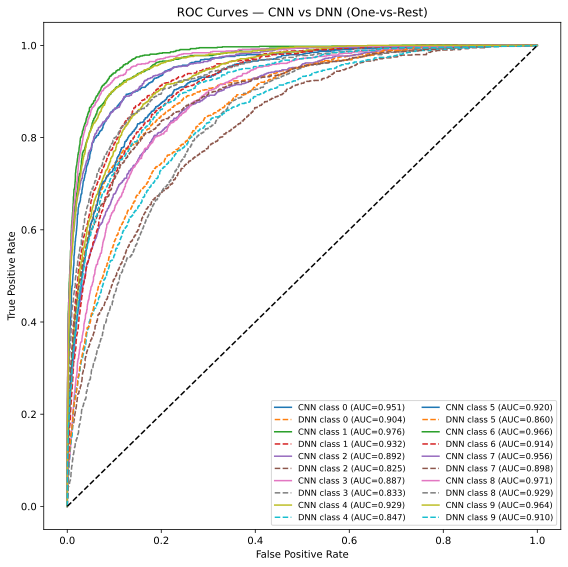

In [16]:
plt.figure(figsize=(8, 8))

for i in range(n_classes):
    plt.plot(cnn_fpr[i], cnn_tpr[i], 
             label=f"CNN class {i} (AUC={cnn_auc[i]:.3f})")
    plt.plot(dnn_fpr[i], dnn_tpr[i], linestyle='--',
             label=f"DNN class {i} (AUC={dnn_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], 'k--')  # diagonal baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — CNN vs DNN (One-vs-Rest)")
plt.legend(ncol=2, fontsize="small")
plt.tight_layout()

In [18]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

313/313 [==============================] - 1s 3ms/step


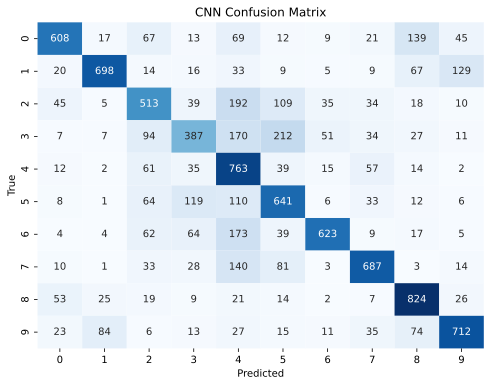

In [25]:
y_pred_dnn = np.argmax(cnn.predict(x_test), axis=1)
plot_confusion_matrix(y_test, y_pred_dnn, title="CNN Confusion Matrix")

313/313 [==============================] - 1s 3ms/step


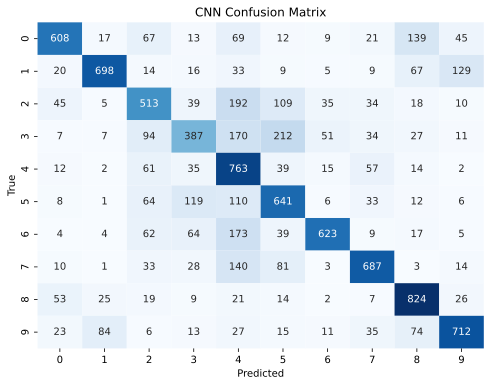

In [26]:
y_pred_cnn = np.argmax(cnn.predict(x_test), axis=1)
plot_confusion_matrix(y_test, y_pred_cnn, title="CNN Confusion Matrix")